## Train NN in SL

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
mcs = [ 'BPSK 1/2', 'BPSK 3/4', 'QPSK 1/2', 'QPSK 3/4',
        '16QAM 1/2', '16QAM 3/4', '64QAM 2/3', '64QAM 3/4']

## Read and prepare data

In [6]:
# load data
df = pd.read_csv('../agentdata/rssi_sl_raw_long.csv')

In [7]:
# get dataset of best action for each observation (obs and label)
cols = []
for i in range(64):
    cols.append('Sc' + str(i))

df['Run'] = df.apply(lambda row: int(row.name / 8), axis=1)
df = df[df['Reward'] > 0.0]

obs = []
label = []
dist = []
maxrewards = []

for run in df['Run'].unique():
    runData = df[df['Run'] == run]
    myid = runData['Reward'].idxmax()
    myrow = df.loc[myid]
    label.append(myrow['Action'])
    maxrewards.append(myrow['Reward'])
    obs.append(myrow[cols].to_numpy())
    dist.append(myrow['Dist'])
    df.loc[df.Run == run, "Best"] = myrow['Action']

## Train the model

In [8]:
a_size = 8
model = keras.Sequential()
model.add(keras.layers.Dense(1, input_shape=(1,), activation='sigmoid'))
model.add(keras.layers.Dense(a_size , activation='relu'))
model.add(keras.layers.Dense(a_size, activation='relu'))
model.add(keras.layers.Dense(a_size, activation='softmax'))
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 72        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
# take average observation over all 64 subcarriers
data = []
for elem in obs:
    elem = np.average([elem[11], elem[25], elem[39], elem[53]])
    elem = (elem - 0) / 45 
    elem = np.reshape(elem, [1, ])
    data.append(elem)
data = np.array(data)

In [10]:
# randomize data
new_data = data
new_label =[]
new_label.extend(label)

for i in range(5):
    new_data = np.append(new_data, data + np.random.normal(0,0.005,len(data)).reshape(len(data),1))
    new_label.extend(label)
len(new_data)

6594

In [11]:
total_epochs = int(100)
model.fit(new_data, new_label,
                validation_split=0.2,
                epochs=total_epochs,
                batch_size=32)

Train on 5275 samples, validate on 1319 samples
Epoch 1/100
5275/5275 [==============================] - 1s 158us/sample - loss: 2.0063 - acc: 0.2593 - val_loss: 1.9646 - val_acc: 0.2578
Epoch 2/100
5275/5275 [==============================] - 0s 77us/sample - loss: 1.9440 - acc: 0.2620 - val_loss: 1.9326 - val_acc: 0.2578
Epoch 3/100
5275/5275 [==============================] - 0s 72us/sample - loss: 1.9217 - acc: 0.2620 - val_loss: 1.9169 - val_acc: 0.2578
Epoch 4/100
5275/5275 [==============================] - 0s 76us/sample - loss: 1.9104 - acc: 0.2620 - val_loss: 1.9084 - val_acc: 0.2578
Epoch 5/100
5275/5275 [==============================] - 0s 85us/sample - loss: 1.9039 - acc: 0.2620 - val_loss: 1.9033 - val_acc: 0.2578
Epoch 6/100
5275/5275 [==============================] - 0s 85us/sample - loss: 1.9000 - acc: 0.2620 - val_loss: 1.8998 - val_acc: 0.2578
Epoch 7/100
5275/5275 [==============================] - 0s 81us/sample - loss: 1.8966 - acc: 0.2620 - val_loss: 1.8968 - v

5275/5275 [==============================] - 0s 89us/sample - loss: 0.7354 - acc: 0.6955 - val_loss: 0.7282 - val_acc: 0.6960
Epoch 60/100
5275/5275 [==============================] - 0s 71us/sample - loss: 0.7348 - acc: 0.7003 - val_loss: 0.7269 - val_acc: 0.6990
Epoch 61/100
5275/5275 [==============================] - 0s 76us/sample - loss: 0.7342 - acc: 0.6927 - val_loss: 0.7268 - val_acc: 0.6907
Epoch 62/100
5275/5275 [==============================] - 0s 81us/sample - loss: 0.7341 - acc: 0.6950 - val_loss: 0.7252 - val_acc: 0.6907
Epoch 63/100
5275/5275 [==============================] - 0s 77us/sample - loss: 0.7310 - acc: 0.6940 - val_loss: 0.7265 - val_acc: 0.6884
Epoch 64/100
5275/5275 [==============================] - 0s 76us/sample - loss: 0.7296 - acc: 0.6974 - val_loss: 0.7355 - val_acc: 0.6854
Epoch 65/100
5275/5275 [==============================] - 0s 76us/sample - loss: 0.7291 - acc: 0.6961 - val_loss: 0.7229 - val_acc: 0.6876
Epoch 66/100
5275/5275 [================

## Evaluate the model

In [12]:
for test in [0.4, 0.5, 0.6, 0.7]:
    var = model.predict([test])
    print(str(test) +" -> " + str(np.argmax(var)))

0.4 -> 1
0.5 -> 2
0.6 -> 3
0.7 -> 5


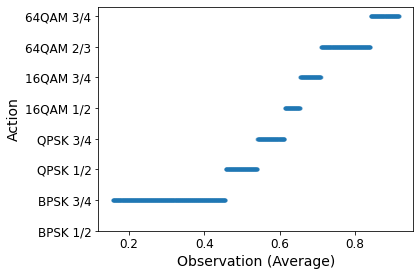

In [17]:
linEval = np.linspace(data.min(), data.max(), num=1000).reshape(-1, 1)
actions= []
for elem in linEval:
    actions.append(np.argmax(model.predict([elem])))
plt.plot(linEval, actions, '.', alpha = 0.5)
plt.yticks(range(8), mcs)
plt.xlabel('Observation (Average)')
plt.ylabel('Action')
plt.tight_layout()
plt.savefig('eval_nn_agent.pdf')
plt.savefig('eval_nn_agent.png')

## Show measurement data

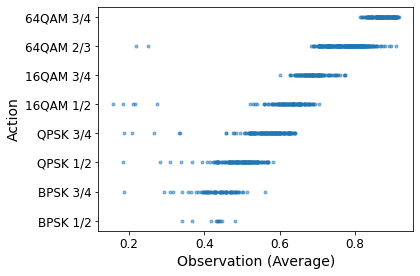

In [29]:
plt.plot(data, label, '.', alpha = 0.5)
plt.yticks(range(8), mcs)
plt.xlabel('Observation (Average)')
plt.ylabel('Action')
plt.tight_layout()
plt.savefig('eval_action.pdf')
plt.savefig('eval_action.png')

In [19]:
dfDist = pd.DataFrame(data, columns =['Avg'])
dfDist['Dist'] = dist

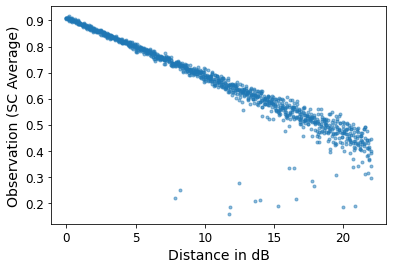

In [20]:
plt.plot(dist, data, '.', alpha = 0.5)
plt.xlabel('Distance in dB')
plt.ylabel('Observation (SC Average)')
plt.savefig('eval_observation.pdf')
plt.savefig('eval_observation.png')

## Compare agent and measurement

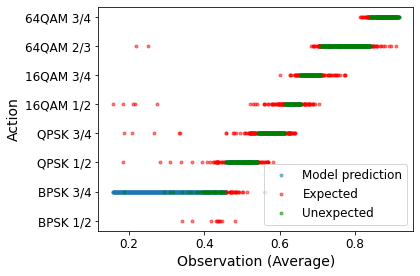

In [28]:
linEval = np.linspace(data.min(), data.max(), num=1000).reshape(-1, 1)
actions= []
for elem in linEval:
    actions.append(np.argmax(model.predict([elem])))
gooddata = []
goodaction = []
baddata = []
badaction = []
for key, elem in enumerate(data):
    predict = np.argmax(model.predict([elem]))
    if label[key] == predict:
        gooddata.append(elem)
        goodaction.append(label[key])
    else:
        baddata.append(elem)
        badaction.append(label[key])
plt.plot(linEval, actions, '.', alpha = 0.5, label="Model prediction")
plt.plot(baddata, badaction, 'r.', alpha = 0.5, label="Expected")
plt.plot(gooddata, goodaction, 'g.', alpha = 0.5, label="Unexpected")
plt.yticks(range(8), mcs)
plt.xlabel('Observation (Average)')
plt.ylabel('Action')
plt.legend()
plt.tight_layout()
plt.savefig('eval_nn_agent_data.pdf')
plt.savefig('eval_nn_agent_data.png')